In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import module as mod

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Exploration des données

Le jeu de données est disponible à cette adresse : https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

**Data Set Information:**

- Data set has no missing values.
- Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
- Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
- All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

In [2]:
data = pd.read_csv('data/ELD2011-2014.zip', sep=';', index_col=0, decimal=',', skiprows=[0], names=[f'house {i}' for i in range(1, 371)])

# we change the index into the proper format
data.index = pd.to_datetime(data.index)
data = data.asfreq('15min')

data.head()

,house 1,house 2,house 3,house 4,house 5,house 6,house 7,house 8,house 9,house 10,...,house 361,house 362,house 363,house 364,house 365,house 366,house 367,house 368,house 369,house 370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data.shape

(140256, 370)

Any NA values ?

In [25]:
data.isna().any().any()

False

Y-a-t-il des données dupliquées ?

In [17]:
data.index.duplicated().any()

False

Sur quelle durée s'étend les mesures ?

In [18]:
print(f'Data from {data.index[0]} to {data.index[-1]}')

Data from 2011-01-01 00:15:00 to 2015-01-01 00:00:00


Affichons la première journée de relevés

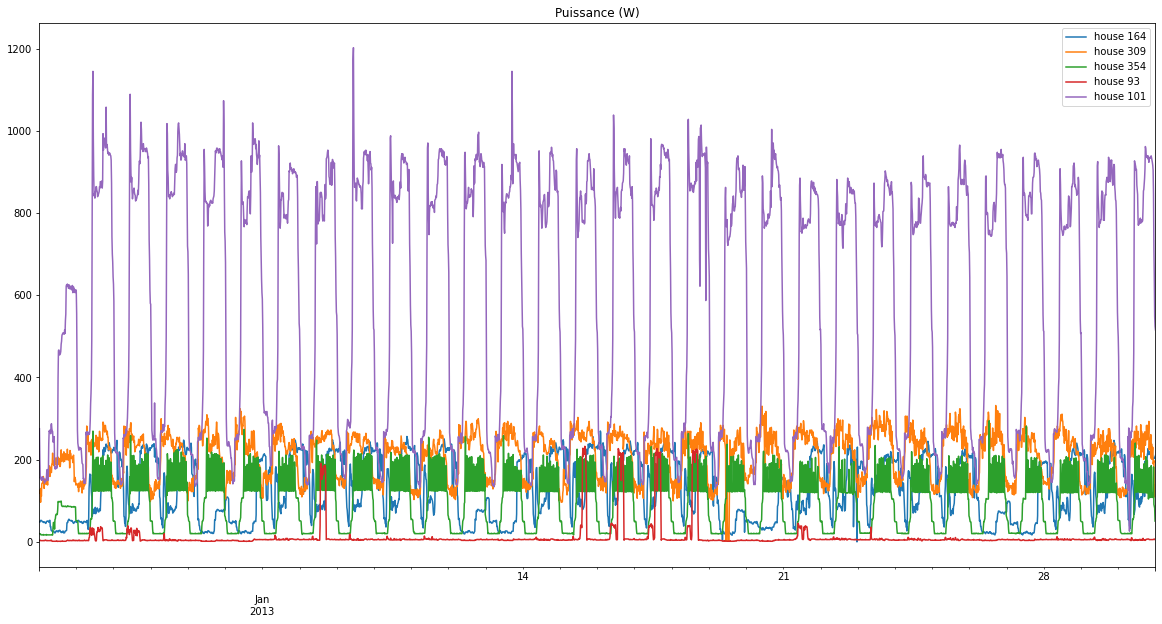

In [11]:
display_window = ['2013-01-01 00:15:00', '2013-01-31 00:00:00']
random_houses = np.random.choice(data.columns, 5, replace=False)

ax = data.loc[display_window[0]:display_window[-1], random_houses].plot(figsize=(20,10), title='Puissance (W)');

Affichons les logements qui consomment le plus.

In [34]:
data.mean().sort_values(ascending=False).head(10)

house 362    37607.987537
house 196    20744.150874
house 279    12038.971232
house 370     8722.355145
house 208     6662.030067
house 228     5782.656826
house 220     2951.449898
house 364     2940.031734
house 194     2675.000006
house 241     2616.867076
dtype: float64

# 2. Classification

On peut essayer d'ajouter des labels à partir d'un classifieur entrainé sur les jeux de données initiaux.

In [3]:
# we load house 1
house1_power_blk2 = mod.load_dataset('data/house1_power_blk2_labels.zip')

# we load house 2
house2_power_blk1 = mod.load_dataset('data/house2_power_blk1_labels.zip')

# we combine both houses
dataset1 = house1_power_blk2.append(house2_power_blk1)
dataset1.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0
2016-03-06 00:00:01,474.0,0,0
2016-03-06 00:00:02,476.0,0,0
2016-03-06 00:00:03,476.0,0,0
2016-03-06 00:00:04,475.0,0,0


In [4]:
dataset1, features_col, _ = mod.generate_scaled_features(dataset1)
dataset1.head()

,mains,activity,hour,mains_scaled,mean_1h_scaled,std_1h_scaled,maxmin_1h_scaled,hour_scaled
datetime,,,,,,,,
2016-03-06 00:00:00,473.0,0,0,-0.308148,-0.400848,-0.747822,-0.749440,-1.661325
2016-03-06 00:00:01,474.0,0,0,-0.306976,-0.400086,-0.747822,-0.747152,-1.661325
2016-03-06 00:00:02,476.0,0,0,-0.304633,-0.398816,-0.745944,-0.742575,-1.661325
2016-03-06 00:00:03,476.0,0,0,-0.304633,-0.398181,-0.746007,-0.742575,-1.661325
2016-03-06 00:00:04,475.0,0,0,-0.305804,-0.398105,-0.746456,-0.742575,-1.661325


In [5]:
# train data set = house 1
X_train = dataset1[features_col].values
y_train = dataset1['activity'].values

Pour nos prédictions nous allons prendre la maison 362, celle qui consomme le plus.

In [11]:
data_house_362 =  data[['house 362']].copy().rename(columns={'house 362': 'mains'})
data_house_362['hour'] = data_house_362.index.hour
data_house_362, _ = mod.generate_scaled_features(data_house_362)

In [14]:
X_test = data_house_362[features_col].values

In [15]:
from sklearn.ensemble import RandomForestClassifier

# we create and train our model
rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.8, max_depth=10)
rfc.fit(X_train, y_train.ravel())

# we make predictions
data_house_362['activity'] = rfc.predict(X_test)

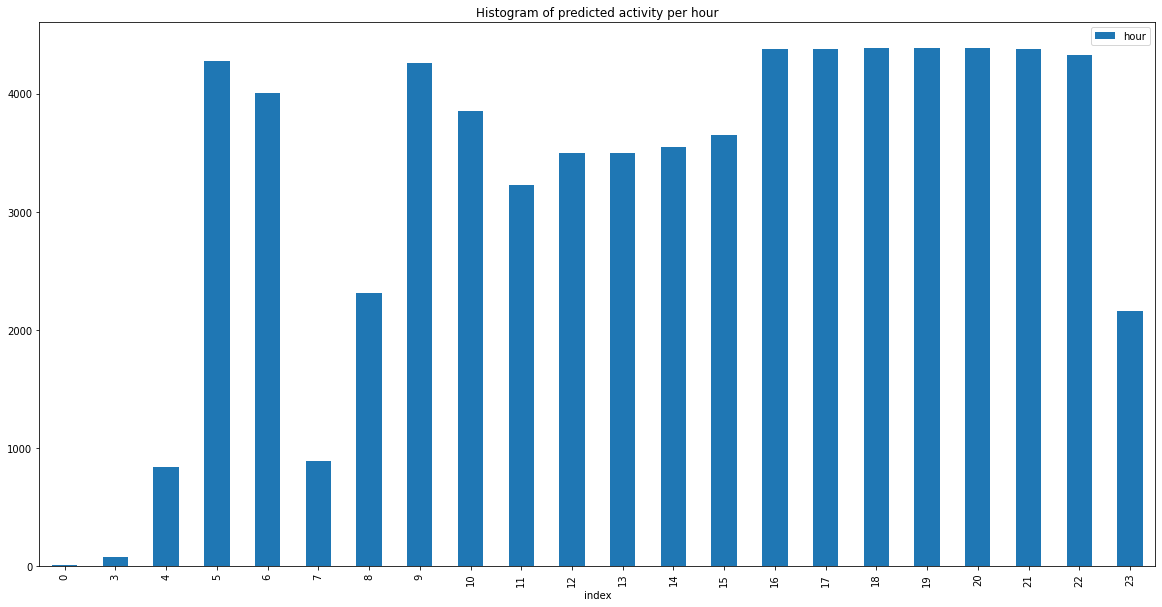

In [18]:
pd.DataFrame(data_house_362.loc[data_house_362['activity'] > 0, 'hour'].value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='hour', figsize=(20,10), legend='Histogramme activité=f(heure)', title='Histogram of predicted activity per hour');

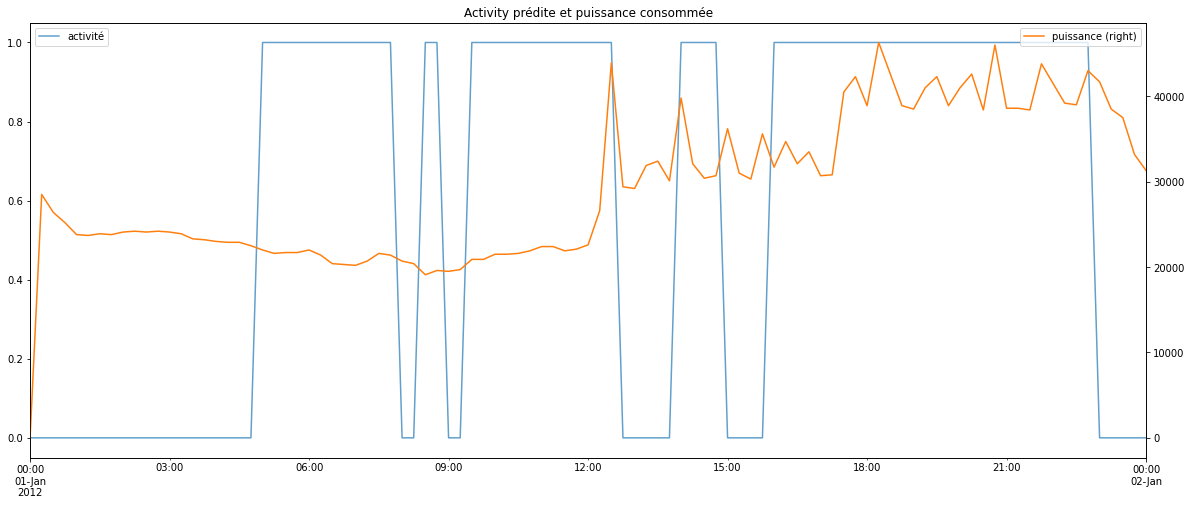

In [25]:
display_window = ['2012-01-01 00:00:00', '2012-01-02 00:00:00']

ax = data_house_362.loc[display_window[0]:display_window[-1], 'activity'].plot(title='Activity prédite et puissance consommée', label='activité', alpha=0.7, figsize=(20,8));
axr = data_house_362.loc[display_window[0]:display_window[-1], 'mains'].plot(secondary_y=True, label='puissance', ax=ax);

ax.legend(loc='upper left');
axr.legend(loc='upper right');